In [1]:
import os
os.chdir("../")

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio.functional as F

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

In [3]:
from src.preprocess.feature_extractor import FeatureExtractor
from src.preprocess.target_processor import TargetProcessor
from clients import gdrive
from src.utils import save_pickle
import constants

In [4]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

---

# Build dataset

In [5]:
TRAIN_SPEAKERS = [
    "1_ines", 
    "2_helena",
    "3_ignasi",
    "4_sonia",
    "5_david",
    "6_gloria",
    "8_diana",
    "9_daniel",
    "10_oriol", 
    "13_tomy",
    "14_maria", 
    "15_arancha",
    "16_tropicfeel",
    "17_robert",
    # "18_lourdes", 
    # "19_pablo",
    "20_anna",
    "21_eirene",
    "22_patricia",
    "23_carlos",
    "25_daniel",
    "26_angel",
    "27_angela",
    "28_joachim",
    "29_alfredo",
]

In [6]:
VALID_SPEAKERS = [
    "30_segolene",
    "31_andrew",
    "32_alexia",
    "33_bernat",
    "34_jon",
    "35_juanjo",
    "36_clara",
    "37_sandra",
]

In [7]:
ALL_SPEAKERS = TRAIN_SPEAKERS + VALID_SPEAKERS

In [8]:
feature_extractor = FeatureExtractor()
target_processor = TargetProcessor()

Upload processed data to gDrive

In [10]:
%%time
os.makedirs(f"data/processed_data/features/", exist_ok=True)
os.makedirs(f"data/processed_data/targets/", exist_ok=True)

x_valid = torch.Tensor([])
y_valid = torch.Tensor([])

for speaker in ALL_SPEAKERS:
    # Extract features and targets
    audio_path = f"data/audio/{speaker}.wav"
    annotation_path = f"data/labels/parsed_annotations/{speaker}.csv"
    current_x = feature_extractor.process_file(audio_path)
    current_y = target_processor.process(annotation_path, size=current_x.shape[1])
    
    # Save as pickle files
    features_pickle_path = f"data/processed_data/features/{speaker}.pickle"
    targets_pickle_path = f"data/processed_data/targets/{speaker}.pickle"
    save_pickle(current_x, features_pickle_path)
    save_pickle(current_y, targets_pickle_path)
    
    # Upload pickles to gDrive
    features_drive_folder_id = "12KIT85SR25p33TEVa3jJU52DItvV7QqP"
    targets_drive_folder_id = "1aY77GI-o8GbPoi1MO0RuPgl2JMgXzBx2"
    gdrive.upload_file(features_pickle_path, features_drive_folder_id)
    gdrive.upload_file(targets_pickle_path, targets_drive_folder_id)

Training set

In [14]:
# %%time
# data_folder = "data/"

# x_train = torch.Tensor([])
# y_train = torch.Tensor([])

# for speaker in TRAIN_SPEAKERS[:1]:
#     audio_path = f"data/audio/{speaker}.wav"
#     annotation_path = f"data/labels/parsed_annotations/{speaker}.csv"
    
#     current_x = feature_extractor.process_file(audio_path)
#     current_y = target_processor.process(annotation_path, size=current_x.shape[1])
    
#     x_train = torch.concat((x_train, current_x), dim=1)
#     y_train = torch.concat((y_train, current_y), dim=0)

Validation set

In [15]:
# %%time
# data_folder = "data/"

# x_valid = torch.Tensor([])
# y_valid = torch.Tensor([])

# for speaker in VALID_SPEAKERS:
#     audio_path = f"data/audio/{speaker}.wav"
#     annotation_path = f"data/labels/parsed_annotations/{speaker}.csv"
    
#     current_x = feature_extractor.process_file(audio_path)
#     current_y = target_processor.process(annotation_path, size=current_x.shape[1])
    
#     x_valid = torch.concat((x_valid, current_x), dim=1)
#     y_valid = torch.concat((y_valid, current_y), dim=0)

### Understand the dataset

In [17]:
def convert_target_to_binary(y, threshold):
    y[y >= threshold] = 1
    y[y < threshold] = 0
    return y

In [18]:
pct_test_set = round(100 * y_valid.shape[0] / (y_valid.shape[0] + y_train.shape[0]), 1)
print(f"Test set size: {pct_test_set}%")

Test set size: 41.5%


In [39]:
y = y_train.clone()

In [41]:
y = convert_target_to_binary(y, threshold=0.5)

In [42]:
y[y==1].shape

torch.Size([238])

Text(0.5, 1.0, 'Target distribution is very imbalanced')

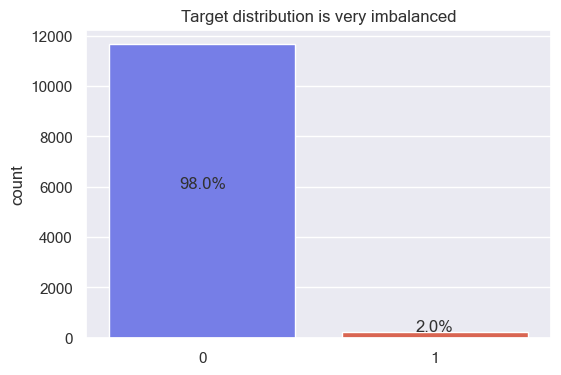

In [43]:
fig,ax = plt.subplots()
sns.countplot(x=y.numpy().astype(int), ax=ax)

# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    pct = 100 * h / y.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(text=text, xy=xy, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")

---

/var/folders/q_/10kbwhdx04lc4nptpgk0fklm0000gp/T/ipykernel_4234/3541903642.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0].get_shared_x_axes().join(axs[0], axs[1])


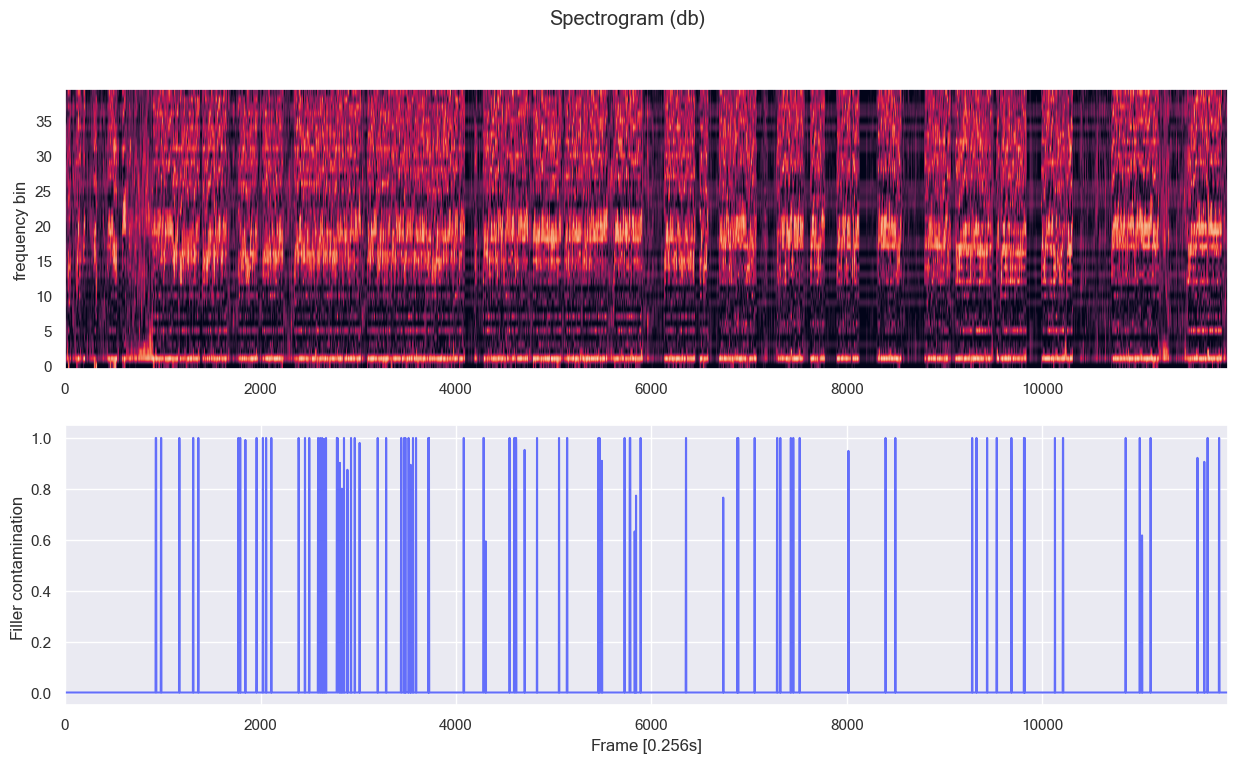

In [46]:
seconds_per_frame = constants.HOP_LENGTH / constants.SAMPLE_RATE

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
fig.suptitle("Spectrogram (db)")

# Plot spectrogram
axs[0].imshow(
    F.amplitude_to_DB(x_train, multiplier=10., amin=0., db_multiplier=20., top_db=80.),
    origin='lower',
    aspect="auto"
)
axs[0].set_ylabel("frequency bin")
axs[0].grid(False)

# Plot targets
axs[1].plot(y_train)
axs[1].set_ylabel("Filler contamination")
axs[1].set_xlabel(f"Frame [{seconds_per_frame}s]")

# Plot
axs[0].get_shared_x_axes().join(axs[0], axs[1])
plt.show(block=False)

---

### Plot the labels

In [22]:
waveform = feature_extractor.load_audio(audio_path)

In [23]:
waveform = feature_extractor.resample(waveform, new_sample_rate=8000)

Sample rate from 48000 to 8000.


/var/folders/q_/10kbwhdx04lc4nptpgk0fklm0000gp/T/ipykernel_3446/3324624114.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0].get_shared_x_axes().join(axs[0], axs[1])


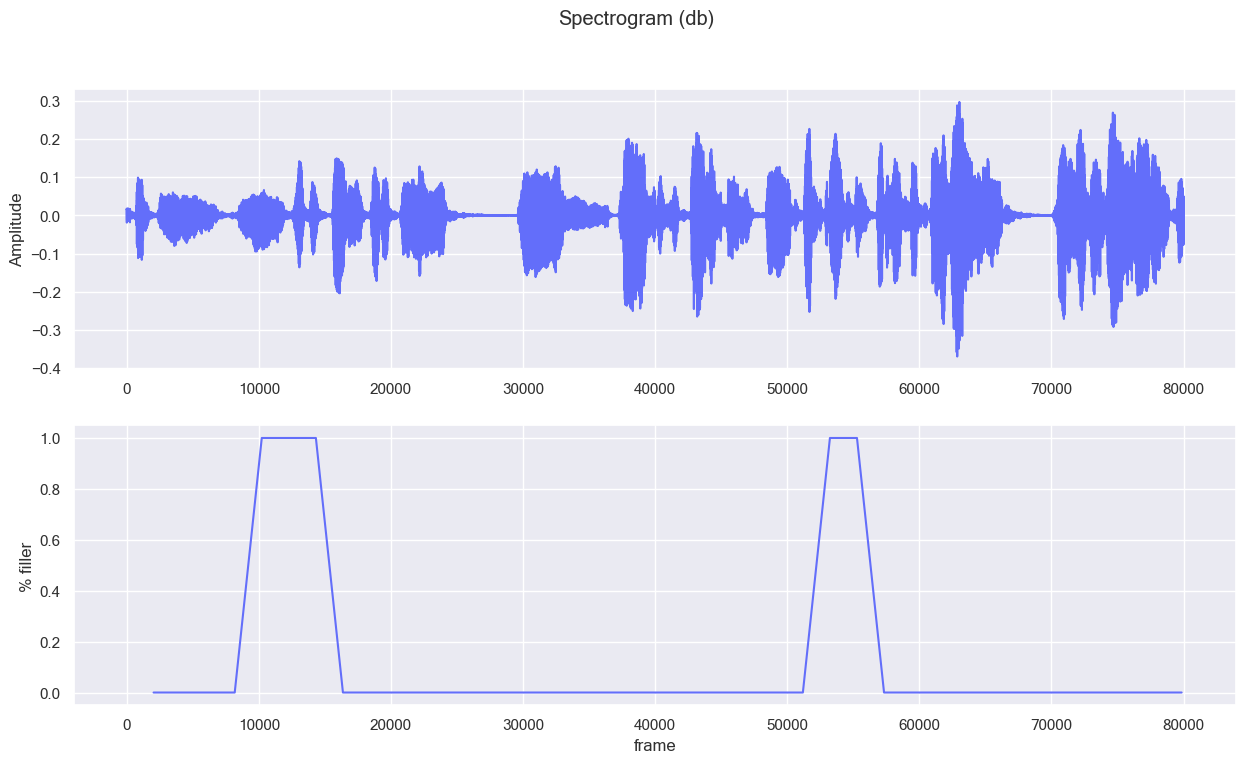

In [24]:
step = 80000
start = int(1e7 * 0.529)
end = int(start + step)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
fig.suptitle("Spectrogram (db)")

# Plot audio waveform
axs[0].plot(waveform.t().numpy()[start:end])
axs[0].set_ylabel("Amplitude")

# Plot targets
x_plot = (np.arange(0, y.shape[0]) * constants.HOP_LENGTH)
mask = (x_plot >= start) & (x_plot < end)
axs[1].plot(x_plot[mask] - start, y[mask])

axs[1].set_xlabel("frame")
axs[1].set_ylabel("% filler")

# Plot
axs[0].get_shared_x_axes().join(axs[0], axs[1])
plt.show(block=False)

---

### Train baseline model: RandomForest

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
from sklearn.model_selection import train_test_split

In [43]:
from sklearn.metrics import average_precision_score

In [91]:
x_train_numpy  = x_train.numpy().transpose()
x_valid_numpy = x_valid.numpy().transpose()
y_train_numpy = y_train.numpy()
y_valid_numpy = y_valid.numpy()

In [93]:
y_train_numpy = convert_target_to_binary(y_train_numpy, threshold=0.8)
y_valid_numpy = convert_target_to_binary(y_valid_numpy, threshold=0.8)

In [94]:
model = RandomForestClassifier(
    n_estimators=200,
    max_features=0.5,
)

In [95]:
model = model.fit(x_train_numpy, y_train_numpy)

In [96]:
y_pred = model.predict(x_valid_numpy)

In [97]:
y_pred_proba = model.predict_proba(x_valid_numpy)[:, 1]

### Evaluate

In [99]:
def print_metrics(y_test, y_pred_proba, threshold=0.5):
    y_pred = convert_target_to_binary(y_pred_proba, threshold=0.5)
    
    metrics = {
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "avg_precision_score": average_precision_score(y_test, y_pred_proba)
    }
    
    print(", ".join([f"{name}: {round(value, 3)}" for name, value in metrics.items()]))

In [102]:
def plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax):
    """Plot the curve with a marker pointing to the current cutoff threshold.
    :param y_test: true target variable
    :param y_pred_proba: prediction probabilities for the positive class (0.0 to 1.0)
    :param threshold: cutoff point to determine the final prediction
    :param ax: matplotlib.plt axis
    :return: None
    """
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
    ax.set_title("Precision-recall curve")
    y_pred = (y_pred_proba >= threshold).astype(float)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ax.plot(
        recall,
        precision,
        marker="x",
        color="r",
        markersize=15,
        label="chosen threshold",
    )
    ax.legend()


In [103]:
def plot_confusion_matrix(y_test, y_pred, ax):
    """
    Plot a confusion matrix on axis.
    :param y_test: true target variable
    :param y_pred: predictions
    :param ax: matplotlib.plt axis
    :return:
    """
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
    ax.grid(False)
    ax.set_title("Confusion matrix")

In [101]:
print_metrics(y_valid_numpy, y_pred_proba)

f1: 0.007, precision: 0.3, recall: 0.004, avg_precision_score: 0.01


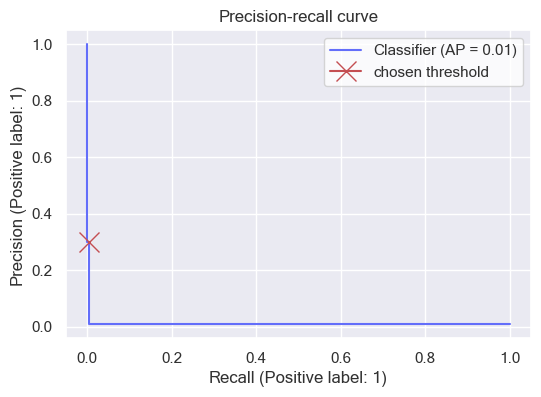

In [104]:
fig, ax = plt.subplots()
plot_precision_recall_curve(y_valid_numpy, y_pred_proba, threshold=0.5, ax=ax)

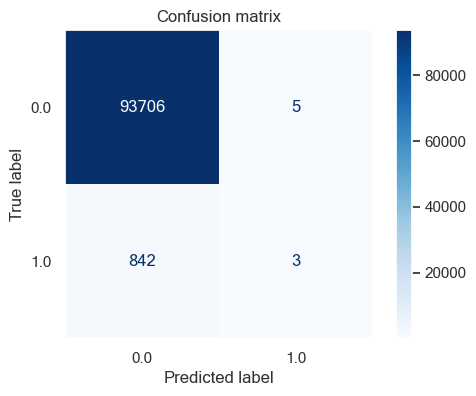

In [105]:
fig, ax = plt.subplots()
plot_confusion_matrix(y_valid_numpy, y_pred, ax=ax)

---